<a href="https://colab.research.google.com/github/akmaleache/Segmentation-/blob/main/Decompose_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementing Decomposition attention paper for predicting if both the questions are similar

In [73]:
from tensorflow.keras.preprocessing.text import Tokenizer, one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam, SGD, Adagrad, Adadelta, RMSprop
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import AUC, Accuracy
from sklearn.model_selection import train_test_split as tts
from tensorflow.keras.layers import LSTM, Embedding, Flatten, Dense, concatenate, Dropout,LeakyReLU, BatchNormalization, Activation, Conv1D, Softmax, Add, Masking
from tensorflow.keras.initializers import he_normal,he_uniform, GlorotNormal,GlorotUniform, Constant
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras import Model,Input
from sklearn.metrics import roc_curve, roc_auc_score
from tensorflow import keras
import pandas as pd
import numpy as np
import tensorflow as tf
import re
from sklearn.model_selection import train_test_split as tts


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# loading data
df = pd.read_csv('/content/drive/MyDrive/Quora project/Quora/train.csv')
df = df[['question1', 'question2','is_duplicate']]
df.dropna(axis=0, inplace=True)
len(df)

404287

In [4]:
# removing numbers
df['question1'] = df['question1'].apply(lambda x : re.sub("(\d*\.\d+)|(\d+\.[0-9 ]+)","",x))
df['question2'] = df['question2'].apply(lambda x : re.sub("(\d*\.\d+)|(\d+\.[0-9 ]+)","",x))

# making all sentence to lower case
df['question1'] = df['question1'].apply(lambda x : x.lower())
df['question2'] = df['question2'].apply(lambda x : x.lower())

# prepending "NULL" in front of each sentence as mention in paper
df['question1'] = df['question1'].apply(lambda x : 'NULL '+x)
df['question2'] = df['question2'].apply(lambda x : 'NUll '+x)

In [ ]:
len(df['question1'][1].split())

8

In [5]:
# installing embedding layer
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip "/content/glove.6B.zip" -d "/content/data"

--2021-07-16 15:32:27--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-07-16 15:32:27--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-07-16 15:32:27--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [6]:
# split for train and test
x = df[['question1','question2']]
y = df['is_duplicate']
x_train,x_test,y_train, y_test = tts(x,y,test_size = 0.20,random_state = 33,stratify = y)

In [7]:
y_train=to_categorical(y_train)
y_test=to_categorical(y_test)
y_train.shape

(323429, 2)

In [8]:
tk = Tokenizer()
tk_test = Tokenizer()
tk.fit_on_texts(x_train['question1']+' '+x_train['question2'])
tk_test.fit_on_texts(x_test['question1']+' '+x_test['question2'])
vocab_size = len(tk.word_index)+1

max_len = 20
q1_train = pad_sequences(tk.texts_to_sequences(x_train['question1']), maxlen=max_len,padding='post')
q2_train = pad_sequences(tk.texts_to_sequences(x_train['question2']),maxlen= max_len,padding='post')

q1_test = pad_sequences(tk_test.texts_to_sequences(x_test['question1']), maxlen=max_len,padding='post')
q2_test = pad_sequences(tk_test.texts_to_sequences(x_test['question2']),maxlen= max_len,padding='post')

q1_train.shape

(323429, 20)

In [10]:
glove_dim = 100
oov = []
embeddings_index = dict()
f = open('/content/data/glove.6B.100d.txt')
for line in f:
    values = line.split()
    if values[0] in tk.word_index:# here we get word_index from above fitted tokeniser 
        embeddings_index[values[0]] = np.asarray(values[1:], dtype='float32')
    else:
        oov.append(values[0])
print('lenght of vocab',len(embeddings_index.keys()))


# create a weight matrix for words in training docs
oov = set()
embedding_matrix = np.zeros((vocab_size, glove_dim))
for word, i in tk.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector
embedding_matrix.shape

lenght of vocab 56166


(86071, 100)

In [24]:
# @tf.function
# def compute_Bi_Aj(x1,x2):
#     #explicitly removing masked input

#     x1 = tf.convert_to_tensor(x1[:tf.where(x1._keras_mask==True)[-1][0]+1])
#     x2 = tf.convert_to_tensor(x2[:tf.where(x2._keras_mask==True)[-1][0]+1])

#     # computing weighted matrix e_ij
#     # e_ij = x1 @ tf.transpose(x2,perm = [0,2,1])
#     # print(e_ij.shape)

    #computing B_i and A_j and returning it to next layer compare



#     # B_sum = [sum(e_ij[0][i][:]) for i in range(e_ij.shape[1])]
#     # A_sum = [sum(e_ij[0][:][j]) for j in range(0,e_ij.shape[2])]


#     # B_i = tf.convert_to_tensor([sum([(e_ij[0][y][x]/B_sum[y])*embdx2[y] for x in range(0,e_ij.shape[2])])  for y in range(0,len(B_sum))])
#     # A_j = tf.convert_to_tensor([sum([(e_ij[0][x][y]/A_sum[y])*embdx1[y] for x in range(0,e_ij.shape[1])])  for y in range(0,len(A_sum))])


    # return(x1,x2)

IndentationError: ignored

## from here on i will make three class for atten, compare, and Aggeragate


In [60]:
class atten(tf.keras.layers.Layer):    
    def __init__(self,vocab_size,output_dim,max_len, estimator,name="attention"):
        super().__init__(name=name)
        self.vocab_size = vocab_size
        self.output_dim = output_dim
        self.max_len = max_len
        self.estimator = estimator

    
    def build(self, input_shape):
        self.embd = Embedding(self.vocab_size, self.output_dim, weights=[embedding_matrix],input_length=self.max_len , mask_zero = True,trainable=False, name = 'emd1')
        self.f = Dense(self.estimator,activation='relu',name = 'F')
        self.softmax_a = Softmax(axis = -1)
        self.softmax_b = Softmax(axis = -1)
        self.m = Masking(mask_value= 0., input_shape=(20, 20))
        self.m2 = Masking(mask_value= 0., input_shape=(20, 100))
        self.m3 = Masking(mask_value= 0., input_shape=(40, 100))


    def call(self, X):
        # here X will a list of two elements
        
        x1,x2 = X[0], X[1] 
        emb1 = self.embd(x1)
        emb2 = self.embd(x2)

        x1 = self.f(emb1)
        x2 = self.f(emb2)

        
        e_ij = x1 @ tf.transpose(x2, perm=[0,2,1])
        e_ij = self.m(e_ij)
        e_ij2 = self.m(tf.transpose(e_ij,perm=[0,2,1]))

        sof1 = self.softmax_a(e_ij,mask = e_ij._keras_mask) 
        sof2 = self.softmax_b(e_ij2 ,mask = e_ij2 ._keras_mask)

        
        B_i = tf.transpose(sof1, perm=[0,2,1]) @ emb1
        B_i = self.m2(B_i)
        A_j = sof2 @ emb2
        A_j = self.m2(A_j)

        v1 = tf.concat([emb1,B_i],1)
        v1 = self.m3(v1)
        v2 = tf.concat([emb2,A_j],1)
        v2 = self.m3(v2)

        
        return (v1,v2)

In [61]:
@tf.function
def summate(x1, x2):
    x1 = tf.reduce_sum(x1,2)
    x2 = tf.reduce_sum(x2,2)
    return (x1,x2)

In [62]:
class compare(tf.keras.layers.Layer):
    def __init__(self, name = 'compare'):
        super().__init__(name = name)
        self.g = Dense(50,activation='relu',name = 'G')
    
    def call(self, X):
        x1,x2 = X[0],X[1]

        x1 = self.g(x1)
        x2 = self.g(x2)

        x1,x2 = summate(x1,x2)

        return (x1,x2)

    

In [63]:
class aggregate(tf.keras.layers.Layer):
    def __init__(self, name = 'aggregate'):
        super().__init__(name = name)
        self.h = Dense(2,activation='sigmoid',name = 'H')
        
    
    def call(self, X):
        x1,x2 = X[0],X[1]
        
        output = tf.concat([x1,x2],-1)
        output = self.h(output)

        return (output)

    

In [66]:
output_dim = 100
estimator = 50

In [67]:
atn = atten(vocab_size,output_dim,max_len,estimator)
com = compare()
agg = aggregate()

In [68]:
# creating dummy model to check if we can build graph of above complex graph
x1_input = Input(shape = max_len, name= 'pair_1')
x2_input = Input(shape = max_len,name = 'pair_2')

vi,vj = atn([x1_input,x2_input])
x1,x2 = com([vi,vj])
output = agg([x1,x2])



In [69]:
model = Model(inputs=[x1_input,x2_input], outputs = [output] )
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
pair_1 (InputLayer)             [(None, 20)]         0                                            
__________________________________________________________________________________________________
pair_2 (InputLayer)             [(None, 20)]         0                                            
__________________________________________________________________________________________________
attention (atten)               ((None, 40, 100), (N 8612150     pair_1[0][0]                     
                                                                 pair_2[0][0]                     
__________________________________________________________________________________________________
compare (compare)               ((None, 40), (None,  5050        attention[0][0]            

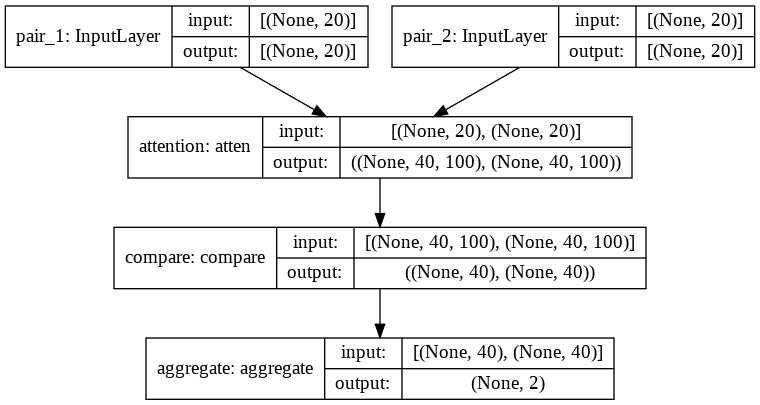

In [51]:
plot_model(model,show_shapes=True)

In [75]:
def auroc(y_true, y_pred):
 return tf.py_function(roc_auc_score, (y_true, y_pred), tf.double)

model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy',AUC()])

In [76]:
model.fit(x = [q1_train,q2_train], y = y_train,batch_size=1, epochs=3, validation_data=([q1_test,q2_test],y_test))

Epoch 1/3
 34656/323429 [==>...........................] - ETA: 10:48 - loss: 0.6204 - accuracy: 0.6632 - auc: 0.7274

KeyboardInterrupt: ignored

# experiment section

In [ ]:
# # now compute Bj and Ai 
# B_sum = [sum(e_ij[i][:]) for i in range(0,e_ij.shape[0])]
# A_sum = [sum(e_ij[:][j]) for j in range(0,e_ij.shape[1])]
# A_sum

# till here i was checking how the mask_zero works in embedding
# B_i = [sum([(e_ij[y][x]/B_sum[y])*b_[y] for x in range(0,e_ij.shape[1])])  for y in range(0,len(B_sum))] 
# A_j = [sum([(e_ij[x][y]/A_sum[y])*a_[y] for x in range(0,e_ij.shape[0])])  for y in range(0,len(A_sum))] 


In [54]:
embd1 = Embedding(vocab_size,output_dim=100, weights=[embedding_matrix],input_length=max_len, mask_zero = True,trainable=False, name = 'emd1')
d1 = Dense(50,activation='relu',name = 'dense')
d2 = Dense(50,activation='relu',name = 'B')
add = Add()
soft1 = tf.keras.layers.Softmax(axis=-1)
soft2 = tf.keras.layers.Softmax(axis=-1)


In [56]:
# Attend
# lets try dot product of two output from 
a_ = embd1(q1_train[0])
b_ = embd1(q2_train[0])

f_a = d1(a_)
f_b = d1(b_)

# f_a = f_a[:tf.where(f_a._keras_mask==True)[-1][0]+1]
# f_b = f_b[:tf.where(f_b._keras_mask==True)[-1][0]+1]

m = Masking(mask_value= 0., input_shape=(20, 20))
e_ij = f_a @ tf.transpose(f_b)
e_ij = m(e_ij)
e_ij2 = m(tf.transpose(e_ij))


sof1 = soft1(e_ij,mask = e_ij._keras_mask) 
sof2 = soft2(e_ij2 ,mask = e_ij2 ._keras_mask)
# print(sof2._keras_mask)

m2 = Masking(mask_value= 0., input_shape=(20, 100))
B_i = tf.transpose(sof1) @ a_
B_i = m2(B_i)
A_j = sof2 @ b_
A_j = m2(A_j)
print(sof1.shape, a_.shape)

m3 = Masking(mask_value= 0., input_shape=(40, 100))
v1 = tf.concat([a_,B_i],0)
v1 = m3(v1)
v2 = tf.concat([b_,A_j],0)
v2 = m3(v2)
print(v1.shape, v2.shape)










# B_sum = [sum(e_ij[0][i][:]) for i in range(e_ij.shape[1])]
# A_sum = [sum(e_ij[0][:][j]) for j in range(0,e_ij.shape[2])]


# B_i = tf.convert_to_tensor([sum([(e_ij[0][y][x]/B_sum[y])*embdx2[y] for x in range(0,e_ij.shape[2])])  for y in range(0,len(B_sum))])
# A_j = tf.convert_to_tensor([sum([(e_ij[0][x][y]/A_sum[y])*embdx1[y] for x in range(0,e_ij.shape[1])])  for y in range(0,len(A_sum))])

(20, 20) (20, 100)
(40, 100) (40, 100)


In [ ]:
a = np.arange(12,dtype=float).reshape(3,4)
a[0][0] = 22
a

array([[22.,  1.,  2.,  3.],
       [ 4.,  5.,  6.,  7.],
       [ 8.,  9., 10., 11.]])

In [ ]:
soft2(a)

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[9.9999917e-01, 3.2932041e-04, 3.2932041e-04, 3.2932041e-04],
       [1.5229968e-08, 1.7980287e-02, 1.7980287e-02, 1.7980287e-02],
       [8.3152804e-07, 9.8169035e-01, 9.8169035e-01, 9.8169035e-01]],
      dtype=float32)>